# Project 3 -- Distributed Storage Systems

## Instructions

Please read carefully:

* Solve the project yourself. No teamwork.
* If you have questions, please post these in the public channel on Slack. The answers may be relevant to others as well. 
* Feel free to import and use any additional Python package you need.
* You are allowed to solve the project using a different programming language. In this case, please send me your full code and instructions how to run it.
* Your code may be tested on similar but not exactly the same inputs.
* Make sure to fill in your `student_name` in the following block below.

In [1]:
student_name = 'David Mihola' # fill with your student name
assert student_name != 'your_student_name', 'Please fill in your student_name before you start.'

## Setup

In a distributed storage system that utilizes consistent hashing, the keys are assigned to nodes as follows. Identifiers are ordered on an identifier circle modulo $2^m$. Key $k$ is assigned to the first node whose identifier is equal to or follows (the identifier of ) $k$ in the identifier space. This node is called the successor node of key $k$. If identifiers are represented as a circle of numbers from $0$ to $2^m − 1$, then `successor(k)` is the first node clockwise from $k$. The identifier circle is also called the Chord ring.

The Chord protocol supports just one operation: given a key, it maps the key onto a node. Depending on the application using Chord, that node might be responsible for storing a value associated with the key. Chord uses consistent hashing to assign keys to Chord nodes. Consistent hashing tends to balance load, since each node receives roughly the same number of keys, and requires relatively little movement of keys when nodes join and leave the system. Please refer to the lecture materials and the paper [Chord: A P2P Lookup Protocol for Internet Applications](https://pdos.csail.mit.edu/papers/ton:chord/paper-ton.pdf) for further details.

Necessary imports:

In [2]:
import hashlib
import numpy as np 
import matplotlib.pyplot as plt

We will consider $m$=`total_slots`=$2^5$. The function below is used to map the key or the host information of a node to a value on the Chord ring.

In [3]:
def hash_fn1(key: str):
    # hash_fn creates an integer equivalent of a SHA256 hash and
    # takes a modulo with the total number of slots in hash space.

    hsh = hashlib.sha256()
    # converting data into bytes and passing it to hash function
    hsh.update(bytes(key.encode('utf-8')))
    # converting the HEX digest into equivalent integer value
    return int(hsh.hexdigest(), 16) % pow(2,5)

def hash_fn2(key: str):
    hash = hashlib.blake2b(digest_size=9)
    hash.update(bytes(key.encode('utf-8')))
    return int(hash.hexdigest(), 16) & ((1 << 5) - 1)

def hash_fn3(key: str):
    hash = hashlib.md5()
    hash.update(bytes(key.encode('utf-8')))
    return int(hash.hexdigest(), 16) & ((1 << 5) - 1)

Below we define several nodes used to store files on a Chord ring. We print hash values of each node.

In [4]:
class StorageNode:
    def __init__(self, name=None, host=None):
        self.name = name
        self.host = host
        
# storage_nodes holding instances of actual storage node objects
storage_nodes = [
    StorageNode(name='A', host='239.67.52.72'),
    StorageNode(name='B', host='137.70.131.229'),
    StorageNode(name='C', host='98.5.87.182'),
    StorageNode(name='D', host='11.225.158.95'),
    StorageNode(name='E', host='203.187.116.210'),
    StorageNode(name='F', host='107.117.238.203'),
    StorageNode(name='G', host='27.161.219.131'),
]

for node in storage_nodes:
    print(f"Node {node.name} has first hash {hash_fn1(node.host):2}, has second hash {hash_fn2(node.host):2}, has third hash {hash_fn3(node.host):2}.")

Node A has first hash 21, has second hash 31, has third hash 14.
Node B has first hash 16, has second hash 22, has third hash 14.
Node C has first hash 18, has second hash  3, has third hash 14.
Node D has first hash 28, has second hash  6, has third hash 17.
Node E has first hash  4, has second hash  8, has third hash  2.
Node F has first hash 29, has second hash 14, has third hash 20.
Node G has first hash 25, has second hash  1, has third hash 12.


We generate movie files and hash them using the same hash function above. The example below generates 15 files.

In [5]:
# Create a list of movie files to be stores on the nodes
def movie_file_list(num_files):
    return [f"f{x}.mov" for x in range(num_files)]

numfiles = 15
filelist = movie_file_list(numfiles)

for file in filelist:
    print(f"File {file} has first hash {hash_fn1(file):2}, has second hash {hash_fn2(file):2}, has third hash {hash_fn3(file):2},")

File f0.mov has first hash 15, has second hash  8, has third hash  1,
File f1.mov has first hash  7, has second hash 18, has third hash 31,
File f2.mov has first hash  6, has second hash  7, has third hash 27,
File f3.mov has first hash  5, has second hash  2, has third hash  5,
File f4.mov has first hash 17, has second hash 21, has third hash 11,
File f5.mov has first hash 30, has second hash 25, has third hash 29,
File f6.mov has first hash 18, has second hash 30, has third hash  5,
File f7.mov has first hash 22, has second hash 24, has third hash 12,
File f8.mov has first hash 24, has second hash 15, has third hash 13,
File f9.mov has first hash 12, has second hash  1, has third hash 27,
File f10.mov has first hash 27, has second hash 22, has third hash 19,
File f11.mov has first hash  7, has second hash  5, has third hash  6,
File f12.mov has first hash 10, has second hash 26, has third hash  3,
File f13.mov has first hash 12, has second hash  1, has third hash 15,
File f14.mov has

## 1 - Visualize Consistent Hashing [5 points]

**Your task:** Given the list of files and nodes above, visualize the Chord ring with keys and nodes mapped.

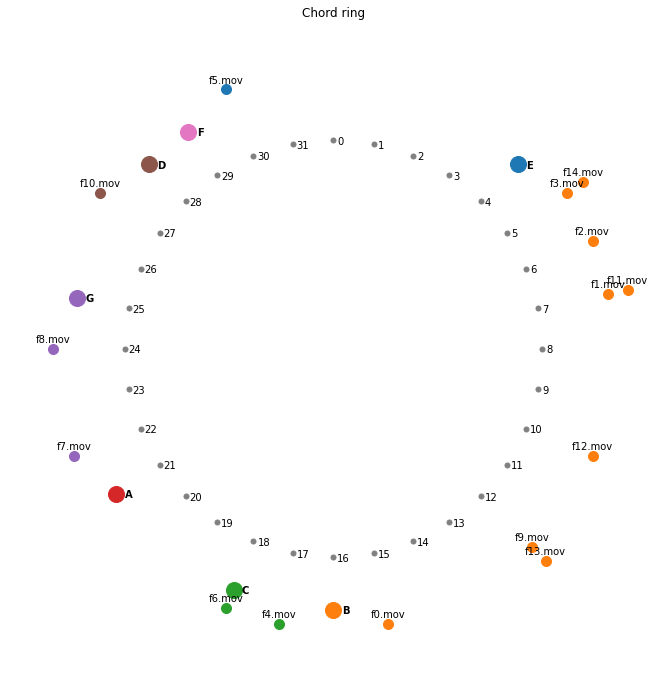

In [6]:
cmap_table = plt.get_cmap("tab10") # pyplot colors
num_keys_on_ring = 1 << 5 # 2^5

num_nodes = len(storage_nodes)
files = [[hash_fn1(file), file] for file in filelist]
nodes = [[hash_fn1(node.host), node.name] for node in storage_nodes]
nodes.sort() # sort the nodes clocwise on the chord ring

angles = np.linspace(-np.pi * 0.5, 1.5 * np.pi, num_keys_on_ring + 1) * -1 # create and rotate the circle correctly

node_angles = angles[[hash for hash, _ in nodes]]
file_angles = angles[[hash for hash, *_ in files]]
for i, file_angle in enumerate(file_angles):
    files[i].append(file_angle)

file_angles_dictonaries = []
for file in files:
    i = 0
    while True:
        if len(file_angles_dictonaries) == i: # all previos circles are full, create new one
            file_angles_dictonaries.append({file[0]: file})
            break
        elif not file_angles_dictonaries[i].get(file[0], False): # empty space in already created circle
            file_angles_dictonaries[i][file[0]] = file
            break
        else:  # circle is already full, move to the next one
            i += 1 

file_circles = [sorted(list(file_angles_dict.values())) for file_angles_dict in file_angles_dictonaries] # order files in each circle clockwise

figure, axis = plt.subplots(1, figsize=(12, 12), facecolor="white")
axis.set_aspect(1)

radius = 8
angles = angles[:num_keys_on_ring]
x = radius * np.cos(angles)
y = radius * np.sin(angles)
axis.scatter(x, y, s=25, c="gray") # plot all keys as a reference
for i, (xi, yi) in enumerate(zip(x, y)):
    axis.annotate(i, (xi + 0.15, yi - 0.15))

radius = 10
x = radius * np.cos(node_angles)
y = radius * np.sin(node_angles)
for i, (xi, yi) in enumerate(zip(x, y)): # plot all nodes 
    axis.plot(xi, yi, marker="o", markersize=16, markerfacecolor=cmap_table(i), markeredgecolor=cmap_table(i))
for i, ((_, node_name), xi, yi) in enumerate(zip(nodes, x, y)):
    axis.annotate(node_name, (xi + 0.32, yi - 0.15), fontweight="bold")

for file_circle in file_circles:
    radius += 0.75 # make sure circles don't overlap
    file_angles = [file_angle for *_, file_angle in file_circle]
    x = radius * np.cos(file_angles)
    y = radius * np.sin(file_angles)
    for i, ((file_hash, *_), xi, yi) in enumerate(zip(file_circle, x, y)):
        for j, (node_hash, _) in enumerate(nodes):
            if file_hash > node_hash and file_hash <= nodes[(j + 1) % num_nodes][0]:
                break
        color = cmap_table((j + 1) % num_nodes) # assign the file to the corrent node
        axis.plot(xi, yi, marker="o", markersize=10, markerfacecolor=color, markeredgecolor=color)

    for i, (file, xi, yi) in enumerate(zip(file_circle, x, y)):
        axis.annotate(file[1], (xi, yi + 0.25), ha="center")

# make the chord ring look better
axis.set_xlim((-radius - 1, radius + 1))
axis.set_ylim((-radius - 1, radius + 1))
axis.set_frame_on(False)
axis.set_xticks([], [])
axis.set_yticks([], [])

plt.title("Chord ring")
plt.savefig("plots/chord_ring", dpi=500)
plt.show()

## 2 - Compute Finger tables in Chord [5 points]

Each Chord node needs “routing” information about only a few other nodes. Because the routing table is distributed, a Chord node communicates with other nodes in order to perform a lookup. In the steady state, in an N-node system, each node maintains information about only O(log N ) other nodes, and resolves all lookups via O(log N ) messages to other nodes. 

**Your task:** Compute a finger table for each node on the Chord ring. The function `compute_finger_tables()` returns a dictionary `{node.name : [finger table entries]}`.

In [7]:
def compute_finger_tables(nodes):
    M = 5
    nodes_hashed = [(hash_fn1(node.host), node.name) for node in nodes]
    nodes_hashed.sort()
    supper_table = [] # contains for every key of the chord ring, which node stores this key
    idx = 0
    for node_hash, node_name in nodes_hashed:
        while idx <= node_hash:
            supper_table.append(node_name)
            idx += 1
    
    max_nodes = 1 << M
    while len(supper_table) < max_nodes: # fill in the remaining with the name of the first node
        supper_table.append(nodes_hashed[0][1])

    finger_tables = {}
    for node_hash, node_name in nodes_hashed:
        finger_table = []
        for i in range(M):
            offset = 1 << i
            finger_table.append(supper_table[(node_hash + offset) % max_nodes]) # find the node, to which the file belong in the super table
        finger_tables[node_name] = finger_table

    return finger_tables

ftabs = compute_finger_tables(storage_nodes)
print(ftabs)

{'E': ['B', 'B', 'B', 'B', 'A'], 'B': ['C', 'C', 'A', 'G', 'E'], 'C': ['A', 'A', 'G', 'D', 'E'], 'A': ['G', 'G', 'G', 'F', 'B'], 'G': ['D', 'D', 'F', 'E', 'B'], 'D': ['F', 'E', 'E', 'E', 'B'], 'F': ['E', 'E', 'E', 'B', 'B']}


## 3 - Find a key [5 points]

**Your task:** Provided an initial node and a key on the ring, print the nodes on the route from the initial node to the node that stores the key. Include the initial node and the destination node in the routing path. Use the finger tables computed above.

In [8]:
def route_to_key(init_node : str, key : int, finger_tables, nodes_dict):
    M = 5
    max_nodes = 1 << M
    max_nodes_mask = max_nodes - 1
    node_list = []
    for _ in range(M): # max log(32) messages
        node_list.append(init_node)
        finger_table = finger_tables[init_node]
        node_hash = hash_fn1(nodes_dict[init_node])
        distance_to_key = (key + max_nodes - node_hash) & max_nodes_mask # make sure the distance is always positive
        for i in range(M):
            if distance_to_key < (1 << i):
                break # node with routing info found
        
        candidate = hash_fn1(nodes_dict[finger_table[i - 1]])
        distance_to_candidate = (candidate + max_nodes - node_hash) & max_nodes_mask
        
        if finger_table[i - 1] == finger_table[0] and distance_to_key <= distance_to_candidate: # the candidate is the successor of the node and it stores the key
            node_list.append(finger_table[0])
            return node_list
        
        for j in range(i, -2, -1): # move backward, stop at -1
            init_node = finger_table[j]
            candidate = hash_fn1(nodes_dict[init_node])
            distance_to_candidate = (key + max_nodes - candidate) & max_nodes_mask
            if distance_to_candidate < distance_to_key:
                break # first preceeding node for the key (predecessor) found

nodes_dict = { node.name: node.host for node in storage_nodes }
print(route_to_key("A", hash_fn1("f0.mov"), ftabs, nodes_dict))

['A', 'F', 'E', 'B']


## 4 - Equal load on every node [5 points]

**Your task:** Generate 1000 key to store in the constructred system (similar to above) and measure the empirical load on every node (=show a bar plot). To improve the load distribution on all nodes, introduce additional hash functions (see [hashlib](https://docs.python.org/3/library/hashlib.html)) and hash the same node to multiple locations on the ring (also see the lecture). Re-run the test and plot the change to the distribution (show the result for using 1, 2 and 3 hash functions).

In [9]:
def assign_files_to_nodes(files, nodes, num_keys_on_ring=32):
    files_per_node = {node_name: [] for _, node_name in nodes} # dictionary of lists of files for each node    

    for file_hashes, *_ in files:
        best_distance = num_keys_on_ring + 1
        best_node_name = None
        best_file_hash = None
        for node_hashes, node_name in nodes: # if two nodes have the same hash, all files will belong to the first node with that hash
            for file_hash, node_hash in zip(file_hashes, node_hashes):
                distance = (node_hash - file_hash + num_keys_on_ring) & (num_keys_on_ring - 1)
                if distance < best_distance:
                    best_distance = distance
                    best_node_name = node_name
                    best_file_hash = file_hash
        files_per_node[best_node_name].append(best_file_hash)

    return files_per_node

def plot_files_distrib(hash_functions, title):
    file_list = movie_file_list(1000)
    files = [[[hash_func(file) for hash_func in hash_functions], file] for file in file_list] # files and their hashes
    nodes = [[[hash_func(node.host) for hash_func in hash_functions], node.name] for node in storage_nodes] # nodes and their hashes
    files_per_node = assign_files_to_nodes(files, nodes)
    bins = np.arange(0, num_nodes + 1) * 10
    counts = [len(files) for files in files_per_node.values()]
    _, axis = plt.subplots(1, figsize=(6, 5), facecolor="white")
    *_, patches = axis.hist(bins[:-1], bins, weights=counts) # artificial histogram

    for i, patch in enumerate(patches):
        patch.set_facecolor(cmap_table(i))

    y_pos = max(counts) * 0.025
    for node_name, x_pos in zip(files_per_node.keys(), bins[:-1] + 5):
        axis.annotate(node_name, (x_pos, y_pos), fontweight="bold", ha="center")

    for count, x_pos in zip(counts, bins[:-1] + 5):
        axis.annotate(str(count), (x_pos, count + 3), ha="center")

    # make the plot look better
    axis.set_xticks([], [])
    axis.set_yticks([], [])
    axis.set_frame_on(False)
    plt.title(title)
    plt.savefig("plots/" + title.lower().replace(" ", "_"), dpi=500)
    plt.show()

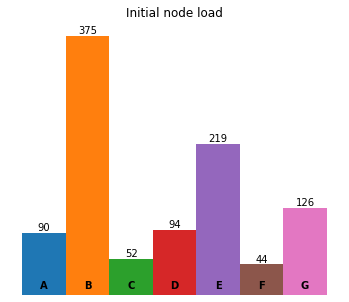

In [10]:
plot_files_distrib([hash_fn1], "Initial node load")

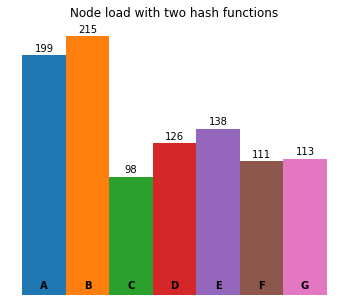

In [11]:
plot_files_distrib([hash_fn1, hash_fn2], "Node load with two hash functions")
# The load improved quite well, as with 'hash_fn1' and 'hash_fn2' there are no nodes mapped on the same key.

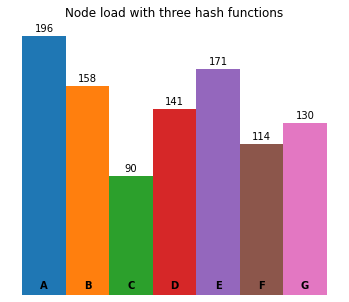

In [12]:
plot_files_distrib([hash_fn1, hash_fn2, hash_fn3], "Node load with three hash functions")
# The load is not improving a lot, because the 'hash_fn3' introduces collisions when mapping nodes onto keys.

## 5 - How to Submit Your Solution?

Download your notebook (File --> Download --> Download .ipynb) and send per email to [saukh@tugraz.at](mailto:saukh@tugraz.at).